In [67]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
data_root = '' # data directory 
Dataset = keras.preprocessing.image_dataset_from_directory(
    directory= data_root, image_size=(128,128), batch_size=32, label_mode=None,
    shuffle=True
).map(lambda x: (x /127.5)-1)

Found 12445 files belonging to 1 classes.


In [61]:
# helper function
def save_images(epoch, grid_rows=5, grid_columns=5):
    noise = tf.random.normal(shape=(grid_rows *grid_columns, seed_dim))
    gen_imgs = generator(noise)
    gen_imgs = gen_imgs* 0.5 + 0.5

    fig, axs = plt.subplots(grid_rows, grid_columns, figsize=(16,16), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    cnt = 0
    for i in range(grid_rows):
      for j in range(grid_columns):
        axs[i, j].imshow(gen_imgs[cnt, :,:,:])
        axs[i, j].axis('off')
        cnt += 1
    plt.savefig(f'generated-images-epoch-{epoch}')
    plt.close()

##discriminator

In [10]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128,128,3)),
        layers.Conv2D(32, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(64, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(128, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(128, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(256, kernel_size=3, strides=1, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(256, kernel_size=3, strides=1, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ]
)

In [11]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        864       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18432     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                      

##generator

**Two common types of layers that can be used in the generator model are a upsample layer (UpSampling2D) that simply doubles the dimensions of the input and the transpose convolutional layer (Conv2DTranspose) that performs an inverse convolution operation**

In [12]:
seed_dim = 90
generator = keras.Sequential(
    [
        keras.Input(shape=(seed_dim,)),
        layers.Dense(4* 4* 256),
        layers.Reshape((4, 4, 256)),
     
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
     
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(128, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(128, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),
     
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, use_bias=False, padding='same'),
        layers.BatchNormalization(momentum=0.75),
        layers.LeakyReLU(0.2),

        layers.Conv2D(3, kernel_size=3, padding='same', use_bias=False, activation='tanh')
    ]
)

In [13]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              372736    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 256)        589824    
 ranspose)                                                       
                                                                 
 batch_normalization_14 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 256)     

##Train

In [14]:
opt_gen = keras.optimizers.Adam(2e-4, 0.5)
opt_disc = keras.optimizers.Adam(1e-4, 0.5)
loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
dloss, gloss = [], []
save_interval = 2500
EPOCHS = 10000
i = 0
for epoch in range(EPOCHS):
  for imgs in tqdm(Dataset):
    i += 1
    batch_size = imgs.shape[0]
    noise = tf.random.normal(shape=(batch_size, seed_dim))
    gen_imgs = generator(noise)

    if i % save_interval == 0:
      save_images(epoch)

    ## Train Discriminator
    with tf.GradientTape() as disc_tape:
      '''In GAN, if the discriminator depends on a small set of features to detect real images,
      the generator may just produce these features only to exploit the discriminator
      To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9'''
      real_label = tf.ones((batch_size, 1)) *tf.constant(0.9)
      gen_label = tf.zeros(batch_size, 1)
      real_pred_disc = discriminator(imgs)
      gen_pred_disc = discriminator(gen_imgs)
      
      loss_disc_real = loss_fn(real_label, real_pred_disc)
      loss_disc_gen = loss_fn(gen_label, gen_pred_disc)
      loss_disc = (loss_disc_real + loss_disc_gen)/2
      dloss.append(loss_disc.numpy())

    grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
    opt_disc.apply_gradients(
        zip(grads, discriminator.trainable_weights)
    )

    ## Train Generator
    with tf.GradientTape() as gen_tape:
      gen_imgs = generator(noise)
      output = discriminator(gen_imgs)
      gen_label = tf.ones(batch_size, 1)
      loss_gen = loss_fn(gen_label, output)
      gloss.append(loss_gen.numpy())

    grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
    opt_gen.apply_gradients(
        zip(grads, generator.trainable_weights)
    )

<Figure size 864x432 with 0 Axes>

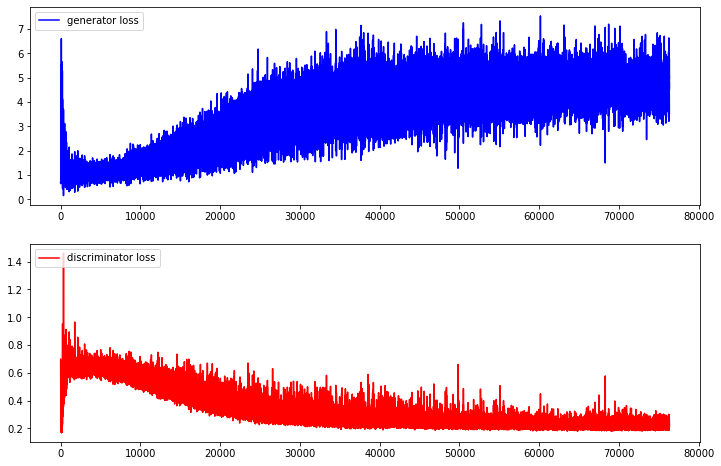

In [49]:
plt.figure(figsize=(12,6))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axes[0].plot(gloss, label='generator loss', color='b')
axes[0].legend(loc='upper left')
axes[1].plot(dloss, label='discriminator loss', color='r')
axes[1].legend(loc='upper left')

In [ ]:
generator.save('generator.h5')